# DNN Optimisation (Removal of has_active_symptoms) in Biochemical Remission

Retrain the network without this feature to simplify for production deployment.
Similar results obtained.

Interesting to look at the feature importance in biochemical remission patients.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    auc,
    roc_curve,
    roc_auc_score,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import shap

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    GroupShuffleSplit,
    GroupKFold,
)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow as tf
import datetime
from tensorflow.keras.metrics import AUC

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
random_seed = 125  # Random seed to ensure reproducibility
output_path = "output/tensorflow_without_active_symptoms_biochem_remission/"
cmap = "seismic"  # Colormap for SHAP plots use "seismic" for full cohort and "berlin" for biochem remission cohort
# file_prefix="tensorflow"
file_prefix = "biochem_remission"

## Data Loading

In [3]:
df = pd.read_csv("working_data/all_ibd_ml_input.csv")
df = df[df["aggregate_disease_activity_Biochemical remission"] == 1] # Uncomment to run biochem remission pipeline

## Further Data Pre-Processing

In [4]:
# convert categorical columns to numerical
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})
df["fatigue_outcome"] = df["fatigue_outcome"].map({"fatigue": 1, "no_fatigue": 0})

In [5]:
# These columns are not features we want to use in the model
# Aggregate disease activity in some ways is a reflection of the other raw variables
columns_to_drop = [
    "aggregate_disease_activity_Active",
    "aggregate_disease_activity_Biochemical remission",
    "aggregate_disease_activity_Remission",
    "season_no_data",
    "study",
    "redcap_event_name_timepoint_1",
    "redcap_event_name_timepoint_2",
    "redcap_event_name_timepoint_3",
    "redcap_event_name_timepoint_4",
    "redcap_event_name_timepoint_5",
]

df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# This column is dropped as all the values are 0.
columns_to_drop = [
    "baseline_eims_pyoderma_gangrenosum",
]

df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# This column is dropped as all the values are 0.
columns_to_drop = [
    "has_active_symptoms",
]

df.drop(columns=columns_to_drop, inplace=True)

## Create Train and Test Datasets

GroupShuffleSplit used to ensure same participant only appears in either train or test set.

In [8]:
# Create Train Validate and Test Datasets

# First split into train and temp 70% train, 30% temp which will be split 50:50 into 15% val and 15% test

# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.36, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    temp_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

groups = train_data["study_id"]  # Group variable for GroupKFold cross-validation

temp_data_splitter = GroupShuffleSplit(
    test_size=0.56, n_splits=1, random_state=random_seed
)

# Perform the split
for val_idx, test_idx in temp_data_splitter.split(
    temp_data, groups=temp_data["study_id"]
):
    val_data = df.iloc[val_idx]
    test_data = df.iloc[test_idx]

X_val = val_data.drop(columns=["fatigue_outcome", "study_id"])
y_val = val_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]


In [9]:
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (170, 79)
Val shape: (43, 79)
Test shape: (54, 79)


In [10]:
numerical_features = [
    "age",
    "height",
    "weight",
    "bmi",
    "age_at_diagnosis",
    "albumin",
    "crp",
    "haemoglobin",
    "red_cell_count",
    "haematocrit",
    "white_cell_count",
    "neutrophils",
    "lymphocytes",
    "monocytes",
    "eosinophils",
    "basophils",
    "platelets",
    "urea",
    "creatinine",
    "sodium",
    "potassium",
    "calprotectin",
    "ada_drug_level",
    "ifx_drug_level",
    "diagnosis_year",
    "disease_duration_weeks",
]
train_scaler = StandardScaler()  # We have tried a variety of scaling methods and they did not affect final model output
train_scaler.fit(X_train[numerical_features])
X_train[numerical_features] = train_scaler.transform(X_train[numerical_features])

test_scaler = StandardScaler()
test_scaler.fit(X_test[numerical_features])
X_test[numerical_features] = test_scaler.transform(X_test[numerical_features])

val_scaler = StandardScaler()
val_scaler.fit(X_val[numerical_features])
X_val[numerical_features] = val_scaler.transform(X_val[numerical_features])


## Deep Learning with TensorFlow


### Model Definition

In [11]:
model = keras.Sequential(
    [
        layers.Dense(384, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(352, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="auc", patience=10, restore_best_weights=True)

### Compiling the Model

In [12]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[AUC()])

In [13]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback],
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.4720 - loss: 0.6603 - val_auc: 0.6295 - val_loss: 0.5988
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.7256 - loss: 0.4938 - val_auc: 0.6756 - val_loss: 0.5620
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.8208 - loss: 0.4674 - val_auc: 0.7038 - val_loss: 0.5665
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.8800 - loss: 0.4065 - val_auc: 0.7231 - val_loss: 0.5814
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9006 - loss: 0.3548 - val_auc: 0.7346 - val_loss: 0.5268
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9125 - loss: 0.3577 - val_auc: 0.7526 - val_loss: 0.5386
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9512 - loss: 0.2865 - val_auc: 0.7641 - val_loss: 0.5491
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9237 - loss: 0.3240 - val_auc: 0.7564 - val_loss: 0.5307
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9432 - loss: 0.2799 -

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384)            │        30,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 352)            │       135,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,188 (1.27 MB)

 Trainable params: 166,593 (650.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,595 (650.77 KB)

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

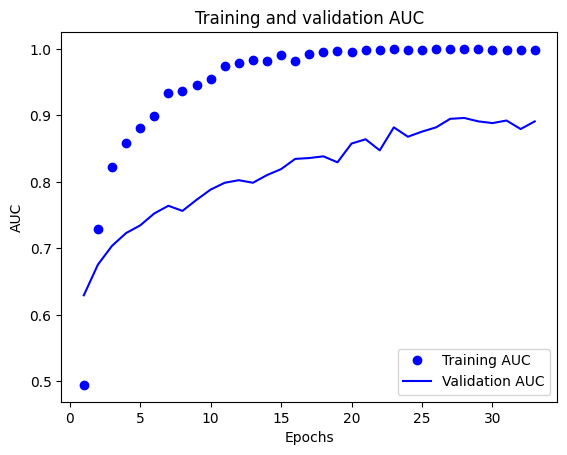

In [16]:
auc_values = history_dict["auc"]
val_auc_values = history_dict["val_auc"]
epochs = range(1, len(auc_values) + 1)
plt.plot(epochs, auc_values, "bo", label="Training AUC")
plt.plot(epochs, val_auc_values, "b", label="Validation AUC")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

save_path = output_path + file_prefix + "_training_vs_validation_loss.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

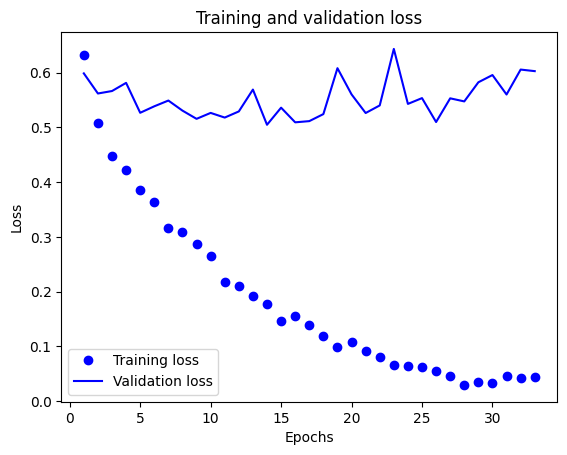

In [17]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

save_path = output_path + file_prefix + "_training_vs_validation_loss.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

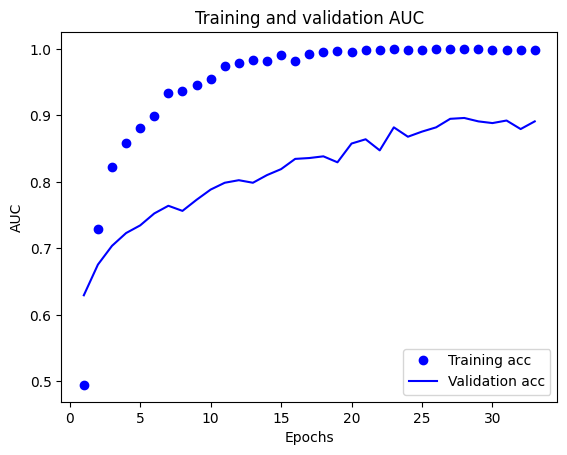

In [18]:
plt.clf()
acc = history_dict["auc"]
val_acc = history_dict["val_auc"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
save_path = output_path + file_prefix + "_training_vs_validation_auc.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [19]:
results = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8809 - loss: 0.3836 


In [20]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1,0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 0.8703703703703703
Sensitivity: 0.5454545454545454
Specificity: 0.9534883720930233
AUC: 0.8985200845665963


In [21]:
np.savetxt(output_path + "dnn_fpr.txt", fpr)
np.savetxt(output_path + "dnn_tpr.txt", tpr)

with open(output_path + "dnn_auc.txt", "w") as f:
    f.write(str(test_auc))

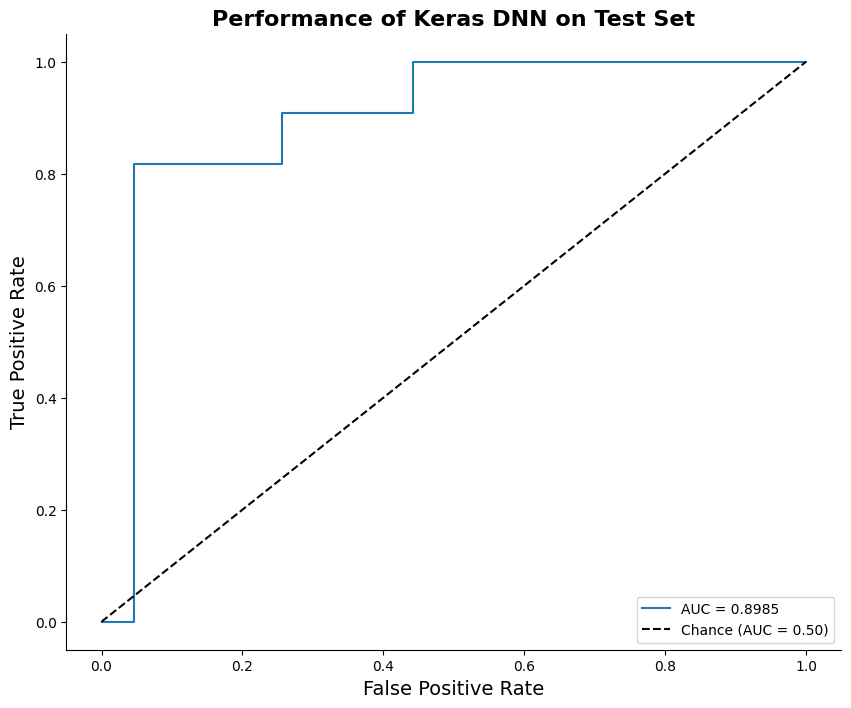

In [22]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr,
    label=f"AUC = {test_auc:.4f}",
)

# Add baseline and plot details
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Performance of Keras DNN on Test Set", fontsize=16, fontweight="bold")
plt.legend(loc="lower right")

# Remove the top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Define the absolute path
save_path = f"{output_path}{file_prefix}_roc_curves.png"

# Save the plot to the specified path
plt.savefig(save_path, dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

## View Tensorboard Output

To launch tensorboard run the following in terminal:

```bash
tensorboard --logdir logs/
```

## SHAP Analysis on Keras DNN Model

In [23]:
explainer = shap.KernelExplainer(model, X_test)
shap_values = explainer.shap_values(X_test)

100%|██████████| 54/54 [00:17<00:00,  3.08it/s]


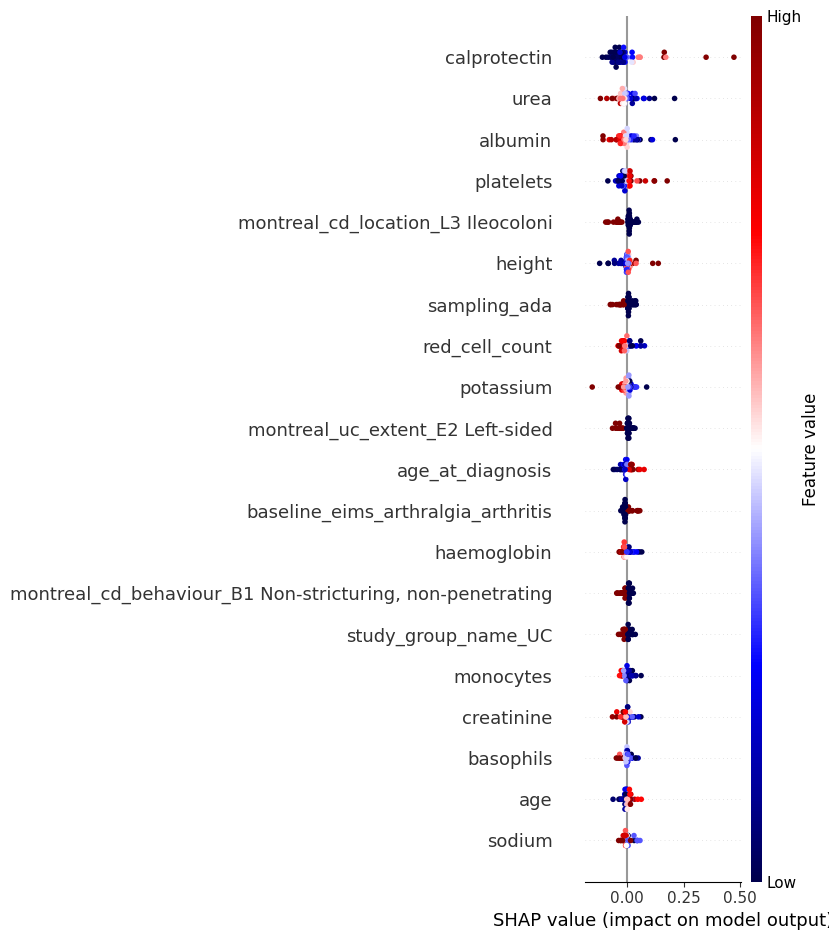

In [24]:
shap_values_class_1 = shap_values[:, :, 0]
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test.columns,
    show=False,
    cmap=cmap,
)

# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_keras_dnn.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

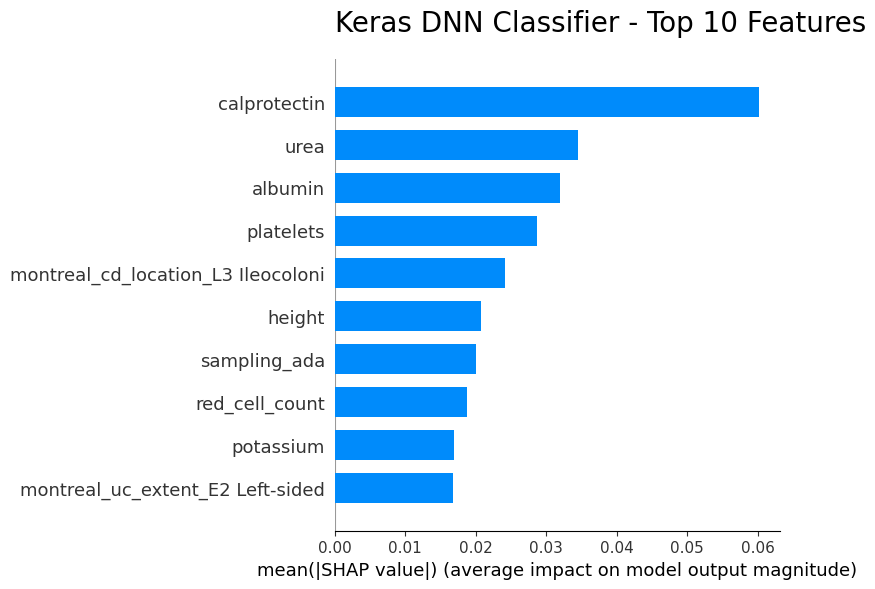

In [25]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test.columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=10,
)


plt.title("Keras DNN Classifier - Top 10 Features", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_keras_dnn_barplot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [26]:
shap.initjs()

In [27]:
X_test_reverted = X_test

In [28]:
X_test_reverted[numerical_features] = test_scaler.inverse_transform(X_test[numerical_features])

In [29]:
X_test_reverted[numerical_features] = X_test_reverted[numerical_features].round(2)

## SHAP Deep Explainer

Deep explainer is much faster than kernel explainer to compute
However it is an approximation and therefore it's results are not the same as kernel explainer

In [30]:
# X_train_sample = shap.sample(X_train, 100)

# X_train_sample_np_array = X_train_sample.to_numpy()
# deep_explainer = shap.DeepExplainer(model, X_train_sample_np_array)
# shap_values = deep_explainer.shap_values(X_train_sample_np_array, output_rank_order="max_abs")

In [31]:
# shap_values_class_1 = shap_values[:, :, 0]
# shap.summary_plot(
#     shap_values_class_1,
#     X_train_sample,
#     feature_names=X_train_sample.columns,
#     show=False,
#     cmap=cmap,
# )

# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

# # save_path = f"{output_path}shap_keras_dnn.png"
# # plt.savefig(save_path, dpi=300, bbox_inches="tight")
# plt.show()

In [32]:
# Find incorrect predictions

outcomes = pd.concat([y_test, pd.Series(y_classes.ravel(), index=y_test.index)], axis=1)
outcomes.columns = ["true", "predicted"]

incorrect_predictions = outcomes[outcomes["true"] != outcomes["predicted"]]
incorrect_predictions = incorrect_predictions.join(X_test_reverted)
incorrect_predictions.to_csv( f"{output_path}forceplots/incorrect_predictions/incorrect_predictions.csv", index=False)
shap_values_incorrect_predictions = pd.DataFrame(shap_values_class_1, index=y_test.index)
shap_values_incorrect_predictions = shap_values_incorrect_predictions.loc[incorrect_predictions.index]
shap_values_incorrect_predictions = shap_values_incorrect_predictions.to_numpy()
X_test_reverted_incorrect_predictions = X_test_reverted.loc[incorrect_predictions.index]
X_test_reverted_incorrect_predictions.reset_index(inplace=True)
X_test_reverted_incorrect_predictions.drop(columns=["index"], inplace=True)

In [33]:
for i in range(len(shap_values_incorrect_predictions)):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_incorrect_predictions[i],
        X_test_reverted_incorrect_predictions.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplots/incorrect_predictions/keras_dnn_forceplot_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")